In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install unidecode
!pip install tqdm

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128,expandable_segments:True"
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from unidecode import unidecode
from tqdm import tqdm

In [ ]:
# Tensor folders
BASE_DIR = r"/content/drive/MyDrive/APS360_Project"
TRAIN_TENSOR_FOLDER = os.path.join(BASE_DIR, "combined_tensors_train")
VAL_TENSOR_FOLDER   = os.path.join(BASE_DIR, "combined_tensors_val")
TEST_TENSOR_FOLDER  = os.path.join(BASE_DIR, "combined_tensors_test")

!cp "/content/drive/MyDrive/APS360_Project/final_train_metadata.csv" /tmp/
!cp "/content/drive/MyDrive/APS360_Project/final_val_metadata.csv" /tmp/
!cp "/content/drive/MyDrive/APS360_Project/final_test_metadata.csv" /tmp/

# Update CSV paths to point to local copies
TRAIN_METADATA = "/tmp/final_train_metadata.csv"
VAL_METADATA   = "/tmp/final_val_metadata.csv"
TEST_METADATA  = "/tmp/final_test_metadata.csv"

CHECKPOINT_PATH = os.path.join(BASE_DIR, "BestModelCheckpoint.pth")

INPUT_SIZE  = 39
OUTPUT_SIZE = 11
BATCH_SIZE  = 4
PATIENCE    = 3
DEBUG = False

In [ ]:
# Collate function to process a batch of data
def collate(batch):
    if DEBUG:
        print("[collate] Received a batch of size:", len(batch))

    # Separate tensors and labels, convert tensors to float and ensure they are contiguous
    tensors, labels = zip(*batch)
    tensors = [tensor.float().contiguous() for tensor in tensors]

    # Pad tensors to the same length and stack labels into a tensor
    padded_tensors = pad_sequence(tensors, batch_first=True, padding_value=0)
    labels = torch.stack(labels, dim=0)

    # Get original sequence lengths and pack the padded tensors
    sequence_lengths = torch.tensor([len(tensor) for tensor in tensors], dtype=torch.long)
    if DEBUG:
        print("[collate] Padded tensors shape:", padded_tensors.shape)
        print("[collate] Sequence lengths:", sequence_lengths.tolist())
    packed_input = pack_padded_sequence(
        padded_tensors,
        sequence_lengths,
        batch_first=True,
        enforce_sorted=False
    )

    # Ensure the packed data is contiguous
    if not packed_input.data.is_contiguous():
        packed_input = torch.nn.utils.rnn.PackedSequence(
            packed_input.data.contiguous(),
            packed_input.batch_sizes,
            packed_input.sorted_indices,
            packed_input.unsorted_indices
        )

    if DEBUG:
        print("[collate] Returning packed_input and labels.\n")
    return packed_input, labels


In [ ]:
class TensorDataset(Dataset):
    def __init__(self, tensor_folder, metadata_csv):
        # Initialize dataset (load metadata and list tensor files.)
        if DEBUG:
            print(f"\n[TensorDataset] Initializing dataset for folder: {tensor_folder}")
        self.tensor_folder = tensor_folder

        if DEBUG:
            print(f"[TensorDataset] Reading metadata from {metadata_csv}")
        self.df = pd.read_csv(metadata_csv)
        self.df[self.df.columns[0]] = self.df[self.df.columns[0]].apply(unidecode)
        self.file_list = os.listdir(tensor_folder)
        if DEBUG:
            print(f"[TensorDataset] Found {len(self.file_list)} files on disk.")
        self.matching_df = self.df[self.df[self.df.columns[0]].isin(self.file_list)].copy()
        self.matching_df.sort_values(by=self.matching_df.columns[0], inplace=True)
        self.labels = self.matching_df.iloc[:, 1:].values
        self.filenames = self.matching_df[self.df.columns[0]].tolist()
        if DEBUG:
            print(f"[TensorDataset] Dataset initialization complete. Total items: {len(self.filenames)}\n")

    def _rename_files(self):
        # Rename files to normalized names.
        fails = []
        for file in os.listdir(self.tensor_folder):
            normalized_name = unidecode(file)
            if file != normalized_name:
                old_file_path = os.path.join(self.tensor_folder, file)
                new_file_path = os.path.join(self.tensor_folder, normalized_name)
                if os.path.exists(old_file_path):
                    try:
                        os.rename(old_file_path, new_file_path)
                        if DEBUG:
                            print(f"[TensorDataset] Renamed: {file} -> {normalized_name}")
                    except Exception as e:
                        if DEBUG:
                            print(f"[TensorDataset] Error renaming {file}: {e}")
                        fails.append((file, str(e)))
                else:
                    if DEBUG:
                        print(f"[TensorDataset] File not found, skipping: {file}")
                    fails.append((file, "File not found"))
        if fails and DEBUG:
            print("\n[TensorDataset] Failed renames in folder:", self.tensor_folder)
            for f in fails:
                print(f"  - {f}")

    def __len__(self):
        # Return total number of items in the dataset.
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load and return the tensor and corresponding label for the given index.
        fname = self.filenames[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        tensor_path = os.path.join(self.tensor_folder, fname)
        data_array = np.load(tensor_path, mmap_mode='r')
        tensor = torch.tensor(data_array, dtype=torch.float32).contiguous()
        if tensor.shape[0] > MAX_SEQ_LEN:
            tensor = tensor[:MAX_SEQ_LEN, :]
        if DEBUG and idx % 50 == 0:
            print(f"[TensorDataset] Loading item {idx}: {fname} with shape {tensor.shape}")
        return tensor, label

def create_data_loader(tensor_folder, metadata_csv, batch_size=BATCH_SIZE, shuffle=False):
    # Create and return a DataLoader for the TensorDataset.
    if DEBUG:
        print(f"\n[create_data_loader] Creating DataLoader for folder: {tensor_folder}")
    dataset = TensorDataset(tensor_folder, metadata_csv)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
        collate_fn=collate
    )
    if DEBUG:
        print(f"[create_data_loader] DataLoader created with {len(dataset)} samples and batch_size={batch_size}.\n")
    return loader


In [ ]:
class MusicGRU(nn.Module):
    def __init__(self, input_size, hidden_size=256, output_size=OUTPUT_SIZE, num_layers=5, dropout=0.3):
        super(MusicGRU, self).__init__()
        if DEBUG:
            print(f"[MusicGRU] Initializing MusicGRU with input_size={input_size}, hidden_size={hidden_size}, "
                  f"output_size={output_size}, num_layers={num_layers}, dropout={dropout}.")
        # Initialize GRU, normalization, and output layers
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if DEBUG:
            print("[MusicGRU.forward] Forward pass started.")
        # Processes input as a PackedSequence if this part is required
        if isinstance(x, torch.nn.utils.rnn.PackedSequence):
            if not x.data.is_contiguous():
                if DEBUG:
                    print("[MusicGRU.forward] Making PackedSequence data contiguous.")
                x = torch.nn.utils.rnn.PackedSequence(
                    x.data.contiguous(),
                    x.batch_sizes,
                    x.sorted_indices,
                    x.unsorted_indices
                )
            self.gru.flatten_parameters()
            try:
                _, hidden = self.gru(x)
            except RuntimeError as e:
                if DEBUG:
                    print("RuntimeError in GRU with PackedSequence. Disabling cuDNN for this call.")
                with torch.backends.cudnn.flags(enabled=False):
                    _, hidden = self.gru(x)
            out = hidden[-1]
        else:
            if DEBUG:
                print("[MusicGRU.forward] Input is not a PackedSequence.")
            if not x.is_contiguous():
                if DEBUG:
                    print("[MusicGRU.forward] Making tensor data contiguous.")
                x = x.contiguous()
            x = x.float()
            self.gru.flatten_parameters()
            device = x.device
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
            try:
                out, _ = self.gru(x, h0)
            except RuntimeError as e:
                if DEBUG:
                    print("RuntimeError in GRU with non-packed input. Disabling cuDNN for this call.")
                with torch.backends.cudnn.flags(enabled=False):
                    out, _ = self.gru(x, h0)
            out = out[:, -1, :]
        # Normalize and apply final linear transformation
        out = self.layer_norm(out)
        out = self.fc(out)
        if DEBUG:
            print("[MusicGRU.forward] Forward pass complete.\n")
        return out


In [ ]:
# Training & Evaluation Functions (with Early Stopping)

def train_and_evaluate_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001, patience=3):
    # Setup device, loss, optimizer, and mixed-precision scaler
    print("[train_and_evaluate_model] Starting training...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[train_and_evaluate_model] Using device: {device}")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler()

    # Load checkpoint if available
    if os.path.exists(CHECKPOINT_PATH):
        print(f"[train_and_evaluate_model] Loading checkpoint from {CHECKPOINT_PATH}...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        print(f"[train_and_evaluate_model] Checkpoint loaded! Resuming from epoch {start_epoch} with best_val_loss = {best_val_loss:.4f}\n")
    else:
        start_epoch = 0
        best_val_loss = float('inf')
        print("[train_and_evaluate_model] No checkpoint found. Starting training from scratch.\n")

    train_losses, val_losses = [], []
    training_start_time = time.time()
    last_time_log = training_start_time
    wait = 0  # Early stopping counter

    for epoch in range(start_epoch, num_epochs):
        print(f"\n[train_and_evaluate_model] Epoch {epoch+1}/{num_epochs} - Training Phase")
        model.train()
        total_train_loss = 0

        for batch_idx, (songs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
            current_time = time.time()
            if current_time - last_time_log >= 300:
                elapsed = current_time - training_start_time
                print(f"[train_and_evaluate_model] Time elapsed so far: {elapsed/60:.2f} minutes")
                last_time_log = current_time

            songs, labels = songs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(songs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"[train_and_evaluate_model] Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

        print(f"[train_and_evaluate_model] Epoch {epoch+1}/{num_epochs} - Validation Phase")
        model.eval()
        total_val_loss = 0
        for batch_idx, (songs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")):
            songs, labels = songs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(songs)
                loss = criterion(outputs, labels)
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"[train_and_evaluate_model] Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

        # Save checkpoint if validation improves; else, update early stopping counter
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }
            torch.save(checkpoint, CHECKPOINT_PATH)
            print(f"[train_and_evaluate_model] New best model found! Saving checkpoint at epoch {epoch+1}")
        else:
            wait += 1
            print(f"[train_and_evaluate_model] No improvement in validation loss at epoch {epoch+1}. Wait count: {wait}/{patience}")
            if wait >= patience:
                print("[train_and_evaluate_model] Early stopping triggered!")
                break

        torch.cuda.empty_cache()

    # Plot training and validation loss curves
    print("\n[train_and_evaluate_model] Training complete. Plotting loss curves...")
    plt.figure()
    epochs = list(range(start_epoch + 1, start_epoch + 1 + len(train_losses)))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    print("[train_and_evaluate_model] Training and evaluation finished.\n")


def test_model(model, test_loader):
    # Load the best checkpoint and evaluate model performance on test data
    print("[test_model] Starting testing...")
    from sklearn.metrics import mean_squared_error
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[test_model] Loading model weights from {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    predictions, ground_truths = [], []
    for batch_idx, (songs, labels) in enumerate(tqdm(test_loader, desc="Testing")):
        songs, labels = songs.to(device), labels.to(device)
        with torch.cuda.amp.autocast(dtype=torch.float16):
            outputs = model(songs)
        predictions.append(outputs.detach().cpu())
        ground_truths.append(labels.detach().cpu())
    predictions = torch.cat(predictions, dim=0).numpy()
    ground_truths = torch.cat(ground_truths, dim=0).numpy()
    mse = mean_squared_error(ground_truths, predictions)
    print(f"[test_model] Test MSE: {mse:.4f}\n")
    return predictions, ground_truths, mse


[main] Creating DataLoaders...
[main] Initializing MusicGRU model...
[main] Starting training and evaluation...
[train_and_evaluate_model] Starting training...
[train_and_evaluate_model] Using device: cuda
[train_and_evaluate_model] Loading checkpoint from /content/drive/MyDrive/APS360_Project/BestModelCheckpoint.pth...


<ipython-input-24-eec706c43e65>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


[train_and_evaluate_model] Checkpoint loaded! Resuming from epoch 9 with best_val_loss = 93.2324


[train_and_evaluate_model] Epoch 10/15 - Training Phase


Epoch 10 Training:   0%|          | 0/1535 [00:00<?, ?it/s]<ipython-input-24-eec706c43e65>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 Training:  40%|███▉      | 613/1535 [05:00<13:38,  1.13it/s]

[train_and_evaluate_model] Time elapsed so far: 5.01 minutes


Epoch 10 Training:  78%|███████▊  | 1199/1535 [10:03<09:22,  1.67s/it]

[train_and_evaluate_model] Time elapsed so far: 10.05 minutes


Epoch 10 Training: 100%|██████████| 1535/1535 [14:36<00:00,  1.75it/s]


[train_and_evaluate_model] Epoch 10 - Training Loss: 93.5619
[train_and_evaluate_model] Epoch 10/15 - Validation Phase


Epoch 10 Validation:   0%|          | 0/371 [00:00<?, ?it/s]<ipython-input-24-eec706c43e65>:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 Validation: 100%|██████████| 371/371 [05:16<00:00,  1.17it/s]


[train_and_evaluate_model] Epoch 10 - Validation Loss: 94.0996
[train_and_evaluate_model] No improvement in validation loss at epoch 10. Wait count: 1/3

[train_and_evaluate_model] Epoch 11/15 - Training Phase


Epoch 11 Training:   0%|          | 1/1535 [00:02<55:56,  2.19s/it]

[train_and_evaluate_model] Time elapsed so far: 19.91 minutes


Epoch 11 Training:  41%|████      | 632/1535 [05:04<20:27,  1.36s/it]

[train_and_evaluate_model] Time elapsed so far: 24.94 minutes


Epoch 11 Training:  68%|██████▊   | 1042/1535 [10:06<10:37,  1.29s/it]

[train_and_evaluate_model] Time elapsed so far: 29.99 minutes


Epoch 11 Training:  91%|█████████▏| 1404/1535 [15:07<02:27,  1.13s/it]

[train_and_evaluate_model] Time elapsed so far: 34.99 minutes


Epoch 11 Training: 100%|██████████| 1535/1535 [16:54<00:00,  1.51it/s]


[train_and_evaluate_model] Epoch 11 - Training Loss: 93.5966
[train_and_evaluate_model] Epoch 11/15 - Validation Phase


Epoch 11 Validation: 100%|██████████| 371/371 [05:04<00:00,  1.22it/s]


[train_and_evaluate_model] Epoch 11 - Validation Loss: 93.5975
[train_and_evaluate_model] No improvement in validation loss at epoch 11. Wait count: 2/3

[train_and_evaluate_model] Epoch 12/15 - Training Phase


Epoch 12 Training:   0%|          | 1/1535 [00:00<09:25,  2.71it/s]

[train_and_evaluate_model] Time elapsed so far: 41.86 minutes


Epoch 12 Training:  41%|████      | 628/1535 [05:00<09:24,  1.61it/s]

[train_and_evaluate_model] Time elapsed so far: 46.86 minutes


Epoch 12 Training:  69%|██████▉   | 1059/1535 [10:02<08:41,  1.10s/it]

[train_and_evaluate_model] Time elapsed so far: 51.88 minutes


Epoch 12 Training:  94%|█████████▍| 1441/1535 [15:03<02:02,  1.30s/it]

[train_and_evaluate_model] Time elapsed so far: 56.91 minutes


Epoch 12 Training: 100%|██████████| 1535/1535 [16:15<00:00,  1.57it/s]


[train_and_evaluate_model] Epoch 12 - Training Loss: 93.5601
[train_and_evaluate_model] Epoch 12/15 - Validation Phase


Epoch 12 Validation: 100%|██████████| 371/371 [04:51<00:00,  1.27it/s]

[train_and_evaluate_model] Epoch 12 - Validation Loss: 93.5731
[train_and_evaluate_model] No improvement in validation loss at epoch 12. Wait count: 3/3
[train_and_evaluate_model] Early stopping triggered!

[train_and_evaluate_model] Training complete. Plotting loss curves...


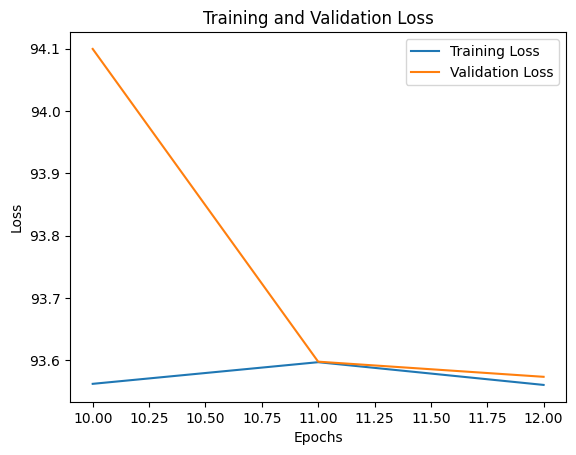

[train_and_evaluate_model] Training and evaluation finished.



In [ ]:
# Main Script
if __name__ == "__main__":
    print("[main] Creating DataLoaders...")
    train_loader = create_data_loader(TRAIN_TENSOR_FOLDER, TRAIN_METADATA, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = create_data_loader(VAL_TENSOR_FOLDER, VAL_METADATA, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = create_data_loader(TEST_TENSOR_FOLDER, TEST_METADATA, batch_size=BATCH_SIZE, shuffle=False)

    print("[main] Initializing MusicGRU model...")
    model = MusicGRU(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE)

    print("[main] Starting training and evaluation...")
    train_and_evaluate_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001, patience=PATIENCE)



In [ ]:
    print("[main] Testing the model...")
    predictions, ground_truths, mse = test_model(model, test_loader)
    print("[main] All steps completed successfully!")

[main] Testing the model...
[test_model] Starting testing...
[test_model] Loading model weights from /content/drive/MyDrive/APS360_Project/BestModelCheckpoint.pth


Testing:   0%|          | 0/366 [00:00<?, ?it/s]<ipython-input-14-eec706c43e65>:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):  # Removed device_type parameter
Testing: 100%|██████████| 366/366 [05:44<00:00,  1.06it/s]

[test_model] Test MSE: 90.1719

[main] All steps completed successfully!
